In [101]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

import seaborn as sns

Basic classification of embeddings with RandomForest: following the OpenAI [tutorial](https://github.com/openai/openai-cookbook/blob/main/examples/Classification_using_embeddings.ipynb)

In [190]:
df = pd.read_csv('../data/sentences_embeddings.csv')

In [191]:
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to array

              precision    recall  f1-score   support

      Biased       0.76      0.74      0.75       342
  Non-biased       0.78      0.80      0.79       393

    accuracy                           0.77       735
   macro avg       0.77      0.77      0.77       735
weighted avg       0.77      0.77      0.77       735



<Axes: >

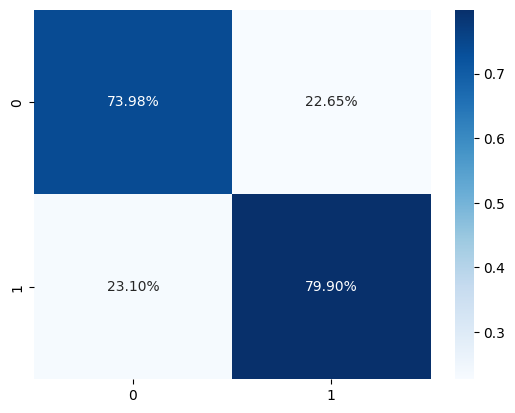

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.label_bias, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)

cf_matrix = confusion_matrix(y_test.values, preds)
sns.heatmap(cf_matrix/cf_matrix.sum(axis=1), annot=True, 
            fmt='.2%', cmap='Blues')

Let's compare this simple classifier's performance on the OpenAI ada embeddings with the performance of the BERT models published in "Neural Media Bias Detection Using Distant Supervision With BABE - Bias Annotations By Experts" by T.Spinde et al.

![F1 scores in published work](../data/f1_paper.png)


We can see that even without a lot of tweaking, our simple model performs almost as well (f1 macro = 0.77) as the BERT models with distant supervision (f1 macro ~ 0.79). In the best models (BERT + distance, RoBERTa + distance), the authors relied on pre-training the word embedding algorithms with the news headlines data:
"*Media bias can be better captured when word embedding algorithms are pre-trained on the news headlines corpus with distant supervision based on varying news outlets*". 

Here we'll try to achieve similar accuracy by another methods which relies on sequential classification by topic and subsequently multilabel classification on the label_bias and label_opinion variables.

Let's first see if my hunch that a kNNs type classifier will be suitable for classifying the topics.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.topic, test_size=0.2, random_state=42
)

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
preds_rf = clf_rf.predict(X_test)
probas_rf = clf_rf.predict_proba(X_test)

report_rf = classification_report(y_test, preds_rf)
print('RF classification report')
print(report_rf)

RF classification report
                                       precision    recall  f1-score   support

                               #metoo       1.00      0.14      0.25         7
                             abortion       0.88      0.65      0.75        34
                   black lives matter       0.40      0.64      0.50        59
                                  blm       0.40      0.06      0.11        31
                          coronavirus       1.00      0.04      0.08        24
                       elections-2020       0.40      0.11      0.17        18
                          environment       0.72      0.72      0.72        29
                               gender       0.75      0.46      0.57        26
                          gun control       0.38      0.42      0.40        43
                          gun-control       0.88      0.29      0.44        24
                          immigration       0.58      0.70      0.64        20
international-politics-and

kNN classification report
                                       precision    recall  f1-score   support

                               #metoo       0.70      1.00      0.82         7
                             abortion       0.78      0.94      0.85        34
                   black lives matter       0.38      0.63      0.47        59
                                  blm       0.48      0.45      0.47        31
                          coronavirus       0.55      0.50      0.52        24
                       elections-2020       0.40      0.44      0.42        18
                          environment       0.64      1.00      0.78        29
                               gender       0.74      0.65      0.69        26
                          gun control       0.60      0.58      0.59        43
                          gun-control       0.75      0.50      0.60        24
                          immigration       0.56      0.90      0.69        20
international-politics-an

<Axes: >

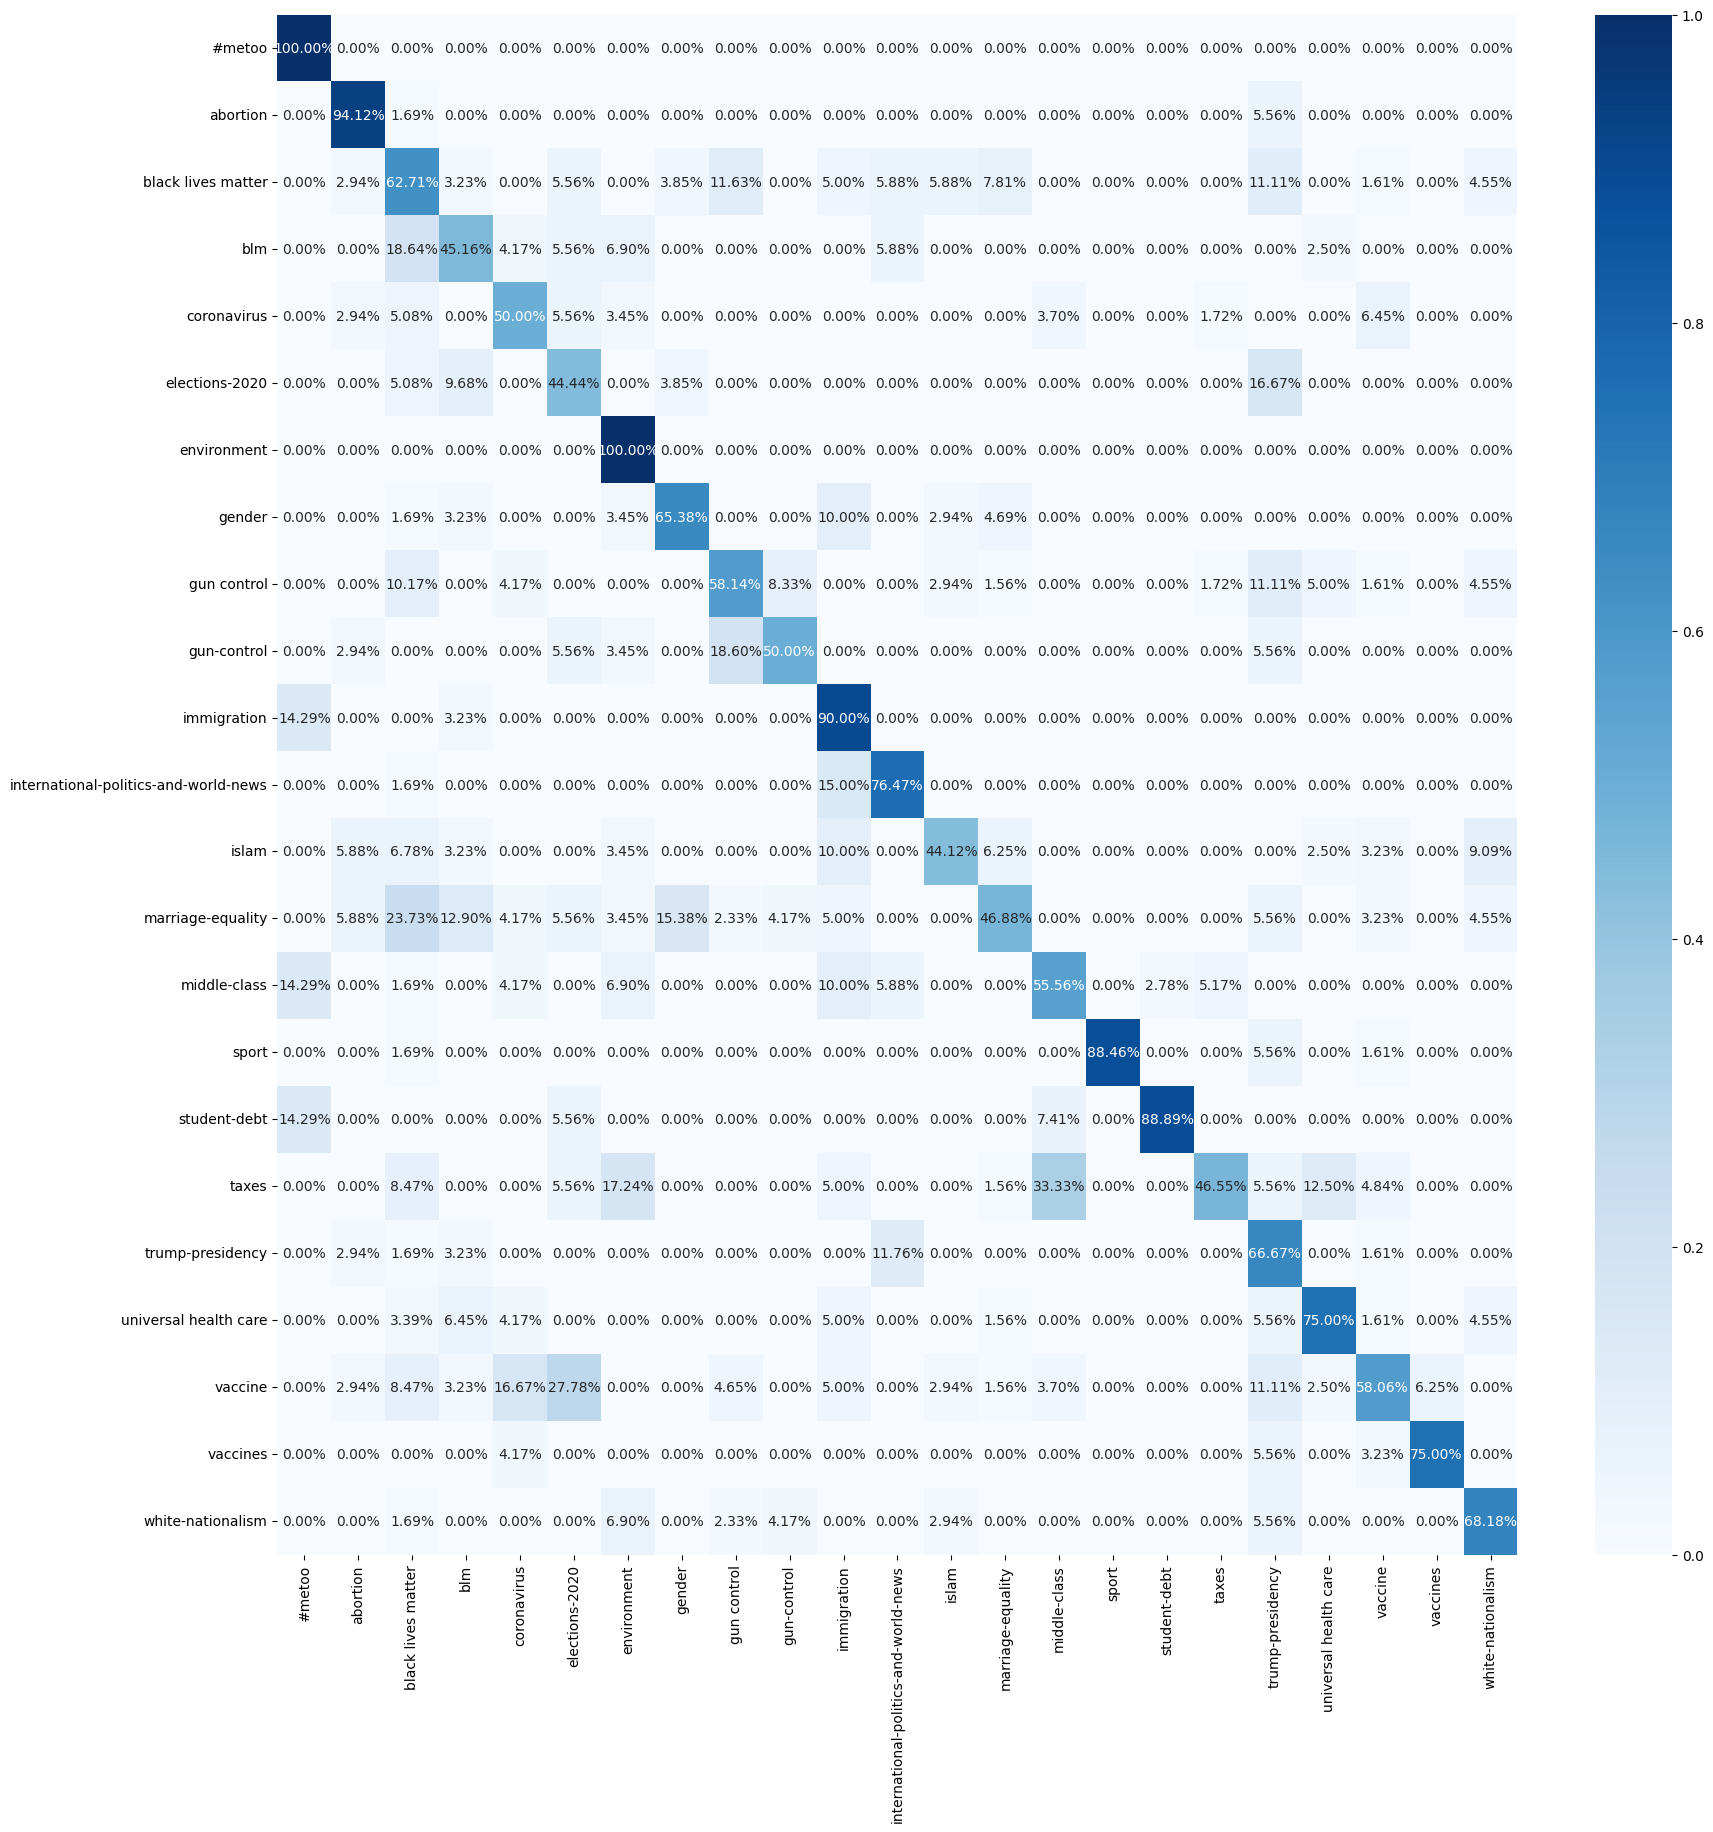

In [73]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print('kNN classification report')
print(report)

cf_matrix = confusion_matrix(y_test.values, preds)

topics = df.topic.unique()
topics.sort()

plt.figure(figsize=(20,20))
sns.heatmap(cf_matrix/cf_matrix.sum(axis=1), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=topics, yticklabels=topics)

We can see that the kNN classifier (f1 weighted = 0.64) performs better than the Random Forest one for topic classification (f1 weighted = 0.49). Not only that, the confusion matrix heatmeap also unveils which topics are more commonly confused with each other and offers additional options for feature engineering. For example, the vaccine topic is most commonly confused  with the coronavirus (logical) and elections-2020 (circumstantial?) topic. Middle-class and taxes are also commonly confused, as well as black lives matter and blm, trump-presidency and international-politics-and-world-news, gun control and gun-control.

This leads me to believe that simpler topic labels may be more beneficial for this project, as we're aiming to first identify a broader topic a sentence belongs to and then identify whether the language used to discuss it is biased or not. In other uses-cases, like news article tagging and database sorting for recommendation systems, it may be more useful to keep the original detailed labels and find ways to improve the classifier on them instead.

In [192]:
new_topics = ['politics', 'socioeconomics', 'activism', 'coronavirus-and-vaccines',
 'environment', 'sport', 'immigration', 'gun-control', 
 'abortion', 'white-nationalism', 'universal-health-care']

new_topics_map = {
    '#metoo':'activism',
    'abortion':'abortion',
    'black lives matter':'activism',
    'blm':'activism',
    'coronavirus':'coronavirus-and-vaccines',
    'elections-2020':'politics',
    'environment':'environment',
    'gender':'socioeconomics',
    'gun control':'gun-control',
    'gun-control':'gun-control',
    'immigration':'immigration',
    'international-politics-and-world-news':'politics',
    'islam':'islam',
    'marriage-equality':'activism',
    'middle-class':'socioeconomics',
    'sport':'sport',
    'student-debt':'socioeconomics',
    'taxes':'socioeconomics',
    'trump-presidency':'politics',
    'universal health care':'universal-health-care',
    'vaccine':'coronavirus-and-vaccines',
    'vaccines':'coronavirus-and-vaccines',
    'white-nationalism':'white-nationalism',
    }

In [193]:
df = df.rename(columns={'topic':'topic_original'})

In [194]:
df['topic'] = df['topic_original'].map(new_topics_map)

In [107]:
df['topic'].unique()

array(['environment', 'gun-control', 'white-nationalism', 'activism',
       'coronavirus-and-vaccines', 'universal-health-care', 'sport',
       'islam', 'socioeconomics', 'politics', 'abortion', 'immigration'],
      dtype=object)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.topic, test_size=0.2, random_state=42
)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print('kNN classification report')
print(report)

# cf_matrix = confusion_matrix(y_test.values, preds)

# topics = df.topic_simple.unique()
# topics.sort()

# plt.figure(figsize=(20,20))
# sns.heatmap(cf_matrix/cf_matrix.sum(axis=1), annot=True, 
#             fmt='.2%', cmap='Blues', xticklabels=topics, yticklabels=topics)

kNN classification report
                          precision    recall  f1-score   support

                abortion       0.78      0.94      0.85        34
                activism       0.68      0.81      0.74       161
coronavirus-and-vaccines       0.78      0.78      0.78       102
             environment       0.69      1.00      0.82        29
             gun-control       0.81      0.69      0.74        67
             immigration       0.62      0.90      0.73        20
                   islam       0.68      0.44      0.54        34
                politics       0.62      0.68      0.65        53
          socioeconomics       0.91      0.72      0.80       147
                   sport       1.00      0.85      0.92        26
   universal-health-care       0.77      0.68      0.72        40
       white-nationalism       0.78      0.64      0.70        22

                accuracy                           0.76       735
               macro avg       0.76      0.76   

With this simple relabeling we have managed to increase the f1 score of the topic classifier by 10%! Now let's see if sequentially classifying the topic first and then the bias, we'll achieve better f1 score on the bias classifier!

## Sequential topic to bias classifier

In [135]:
class SequentialClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, clf_topic, 
                 clf_bias, 
                 clf_opinion,
                ):
        '''
        Initialized a sequential classifier with different models for classifying the topics, bias and factuality.

        Parameters
        ----------
        clf_topic: sklearn.Classifier instance
            The classifier model to use for topics.
        clf_bias: sklearn.Classifier instance
            The classifier model to use for bias.
        clf_opinion: sklearn.Classifier instance
            The classifier model to use for facutuality / opinion.
        '''
        # Initialize each classifier with their provided kwargs
        self.clf_topic = clf_topic
        self.clf_bias = clf_bias
        self.clf_opinion = clf_opinion


    def fit(self, X, Y):
        '''Fits the data by first training a topic classifier and separate bias and factuality classifiers for each topic'''
        self.bias_classifiers = {}
        self.opinion_classifiers = {}

        Y_topic = Y['topic']
        self.clf_topic.fit(X, Y_topic)

        topics = Y['topic'].unique()
        
        for topic in topics:
            topic_mask = Y['topic']==topic
            self.bias_classifiers[topic] = self.clf_bias.fit(X[topic_mask], Y[topic_mask]['label_bias'])
            self.opinion_classifiers[topic] = self.clf_opinion.fit(X[topic_mask], Y[topic_mask]['label_opinion'])
        
        return self
    
    def predict(self, X):
        '''Predicts the topic, bias and factuality for each topic'''
        
        y_predict = pd.DataFrame(np.zeros((X.shape[0], 3)), 
                                 columns= ['topic','label_bias', 'label_opinion'])
        
        y_predict['topic'] = self.clf_topic.predict(X)
        for topic in y_predict['topic'].unique():
            topic_mask = y_predict['topic'] == topic
            y_bias = self.bias_classifiers[topic].predict(X[topic_mask]) 
            y_predict.loc[topic_mask, 'label_bias'] = y_bias
            y_opinion = self.opinion_classifiers[topic].predict(X[topic_mask]) 
            y_predict.loc[topic_mask, 'label_opinion'] = y_opinion
                    
        return y_predict.values

In [123]:
sequential_clf = SequentialClassifier(clf_topic = KNeighborsClassifier(), 
                                      clf_bias = RandomForestClassifier(),
                                      clf_opinion = RandomForestClassifier() 
                                        )

In [124]:
X_train, X_test, y_train, y_test = train_test_split(list(df.embedding.values), df[['topic', 'label_bias', 'label_opinion']], test_size=0.3, random_state=42)
sequential_clf.fit(np.vstack(X_train),y_train)

SequentialClassifier(clf_bias=RandomForestClassifier(),
                     clf_opinion=RandomForestClassifier(),
                     clf_topic=KNeighborsClassifier())

In [127]:
y_pred = sequential_clf.predict(np.vstack(X_test))

In [134]:
report = classification_report(y_test.values[:,1], y_pred[:,1])
print('kNN+RF classification report on the bias column')
print(report)

kNN+RF classification report on the bias column
              precision    recall  f1-score   support

      Biased       0.61      0.67      0.64       524
  Non-biased       0.68      0.62      0.65       579

    accuracy                           0.64      1103
   macro avg       0.65      0.65      0.64      1103
weighted avg       0.65      0.64      0.64      1103



It seems that by adding the topic classifier first we are unnecessarily complicating the model, which leads to a worse performance when it comes to assessing bias. Therefore, let's resort to exploring direct bias classification of the embeddings, but run a grid search with cross validation to determine the best algorithm and hyperparameters of the model.

## Model selection and hyperparameter tuning with GridSearchCV

In [137]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

In [210]:
pipeline_steps = [
    {
        'clf': [LogisticRegression()],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': np.logspace(-4, 4, 5),
    }, 
    {
        'clf': [SVC()],
        'clf__kernel': ['linear', 'rbf'],
        'clf__C': [0.1, 1, 10],
        'clf__gamma': [1, 0.1, 0.01],
    }, 
    {
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': [100, 200, 500],
        'clf__max_depth': [None, 10, 20, 30],
    }, 
    {
        'clf': [GradientBoostingClassifier()],
        'clf__n_estimators': [100, 200, 500],
        'clf__learning_rate': [0.1, 0.05, 0.01],
        'clf__max_depth': [3, 4, 5],
    },
    {
        'clf': [MLPClassifier()],
        'clf__hidden_layer_sizes': [(32, 32), (64, 64), (128, 128)],
        'clf__activation': ['relu', 'tanh'],
        'clf__learning_rate': ['constant', 'invscaling', 'adaptive'],
        'clf__max_iter': [200, 300, 400],
    }
]

In [142]:
pipe = Pipeline([
    ('preprocessing', StandardScaler()), 
    ('clf', None)  # Will be filled in by GridSearchCV
])

grid_search = GridSearchCV(estimator=pipe, param_grid=pipeline_steps, scoring='f1_weighted', n_jobs=-1, cv=5, verbose=2)

In [143]:
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.label_bias, test_size=0.2, random_state=42
)

In [173]:
# Train the GridSearchCV pipeline and fit the best model to the data
grid_search.fit(X_train, y_train)

In [157]:

# Evaluate the best model
y_pred = grid_search.predict(X_test)
f1 = f1_score(y_test.values, y_pred, average="weighted", labels=['Biased', 'Non-biased'])
print(f"Best model: {grid_search.best_estimator_}")
print(f"F1 score: {f1}")

Best model: Pipeline(steps=[('preprocessing', StandardScaler()),
                ('clf', LogisticRegression(C=0.0001))])
F1 score: 0.7900569363588462


Let's finally plot all test scores to see how much better the LogisticRegression model is with respect to all others.

In [195]:
mean_test_scores = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']

model_names = [type(param['clf']).__name__ for param in params]
hyperparams = [str(param) for param in params]

data = {'Model': model_names, 'Hyperparameters': hyperparams, 'F1 Score': mean_test_scores}
df_scores = pd.DataFrame(data)


In [198]:
df_scores

,Model,Hyperparameters,F1 Score
0,LogisticRegression,"{'clf': LogisticRegression(C=0.0001), 'clf__C'...",NaN
1,LogisticRegression,"{'clf': LogisticRegression(C=0.0001), 'clf__C'...",0.790158
2,LogisticRegression,"{'clf': LogisticRegression(C=0.0001), 'clf__C'...",NaN
3,LogisticRegression,"{'clf': LogisticRegression(C=0.0001), 'clf__C'...",0.774114
4,LogisticRegression,"{'clf': LogisticRegression(C=0.0001), 'clf__C'...",NaN
...,...,...,...
116,MLPClassifier,"{'clf': MLPClassifier(), 'clf__activation': 't...",0.777800
117,MLPClassifier,"{'clf': MLPClassifier(), 'clf__activation': 't...",0.784478
118,MLPClassifier,"{'clf': MLPClassifier(), 'clf__activation': 't...",0.778258
119,MLPClassifier,"{'clf': MLPClassifier(), 'clf__activation': 't...",0.781054


In [207]:
fig = px.scatter(df_scores, x='Model', y='F1 Score', color='Hyperparameters')
fig.update_traces(marker_size=12)
fig.update_layout(showlegend=False)

From the graph above we can see that the RF and MLP classifiers perform the best in general, regardless of hyperparameter values, but the best performance with hyperparameter tuning is achieved with the Logistic Regression model with C=0.0001. Since the range of initial values for C was pretty broad (0.0001, 0.1, 10000), let's run one more grid search CV on the Logistic Regression model with more granular sampling around that region.

In [221]:
pipeline_steps_lr = [
    {
        'clf': [LogisticRegression()],
        'clf__penalty': ['l2'],
        'clf__C': np.logspace(-5, -3, 10),
    }, 
]

In [222]:
pipe_lr = Pipeline([
    ('preprocessing', StandardScaler()), 
    ('clf', None)  # Will be filled in by GridSearchCV
])

grid_search_lr = GridSearchCV(estimator=pipe_lr, param_grid=pipeline_steps_lr, scoring='f1_weighted', n_jobs=-1, cv=5, verbose=1)

In [223]:
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('clf', None)]),
             n_jobs=-1,
             param_grid=[{'clf': [LogisticRegression(C=0.00021544346900318823)],
                          'clf__C': array([1.00000000e-05, 1.66810054e-05, 2.78255940e-05, 4.64158883e-05,
       7.74263683e-05, 1.29154967e-04, 2.15443469e-04, 3.59381366e-04,
       5.99484250e-04, 1.00000000e-03]),
                          'clf__penalty': ['l2']}],
             scoring='f1_weighted', verbose=1)

In [224]:
# Evaluate the best model
y_pred_lr = grid_search_lr.predict(X_test)
f1_lr = f1_score(y_test.values, y_pred_lr, average="weighted", labels=['Biased', 'Non-biased'])
print(f"Best model: {grid_search_lr.best_estimator_}")
print(f"F1 score: {f1_lr}")

Best model: Pipeline(steps=[('preprocessing', StandardScaler()),
                ('clf', LogisticRegression(C=0.00021544346900318823))])
F1 score: 0.7859999289348094


In [225]:
mean_test_scores_lr = grid_search_lr.cv_results_['mean_test_score']
params_lr = grid_search_lr.cv_results_['params']


In [226]:
for param,score in zip(params_lr, mean_test_scores_lr):
    print(param['clf__C'], score)

1e-05 0.7674638090120058
1.6681005372000593e-05 0.7712024239353245
2.782559402207126e-05 0.7779868347254455
4.641588833612782e-05 0.7830800757762802
7.742636826811278e-05 0.7884911848714405
0.0001291549665014884 0.7925188493998757
0.00021544346900318823 0.7962541814202512
0.00035938136638046257 0.7952292086969466
0.0005994842503189409 0.79423793259285
0.001 0.7962426184479425


With the second GridSearch we land on a model with C=0.0002 so that's the one we'll use in the pipeline. Of note here is that we haven't managed to improve on the published version with the headline-pre-trained embeddings, but we're not too far off, so using ADA embeddings seems like a good substitute when short on resources to pre-train your own embedding!

## Political bias

Now that we have a model that determines whether a sentence is biased or not, can we push it even further to evaluate whether the bias is left or right leaning in terms of politics based on the outlet bias it comes from?

In [229]:
df['outlet'].unique()

array(['Fox News', 'Alternet', 'MSNBC', 'Breitbart', 'Federalist',
       'Reuters', 'USA Today', 'Daily Beast', 'HuffPost', 'Daily Stormer',
       'New York Times'], dtype=object)

In [238]:
media_bias_map = {
'HuffPost': 'left',
'Federalist': 'right',
'Daily Beast': 'left',
'Alternet': 'left',
'Breitbart': 'right',
'New Yorker': 'left',
'American Greatness': 'right', # from https://mediabiasfactcheck.com/american-greatness/
'Daily Caller': 'right',
'Daily Wire': 'right',
'Slate': 'left',
'Reuters': 'center',
'Hill': 'center', # from https://mediabiasfactcheck.com/the-hill/
'USA Today': 'left',
'CNBC': 'left',
'Yahoo News - Latest News & Headlines': 'left',
'AP': 'left',
'Bloomberg': 'left',
'Fox News': 'right',
'MSNBC': 'left',
'Daily Stormer': 'right', # from https://mediabiasfactcheck.com/the-hill/
'New York Times': 'left'
}

In [239]:
df['outlet_bias'] = df['outlet'].map(media_bias_map)

In [241]:
df['outlet_bias'].value_counts()

outlet_bias
right     1508
left      1405
center     761
Name: count, dtype: int64

Let's try a similar comparison of standalone vs sequential classification approaches. In the sequential classification, we'll first use the bias classifier to determine if a post is biased, and then use a political bias classifier trained only on the left and right posts to determine its political bias.

In [256]:
class SequentialClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, clf_bias, 
                 clf_politics, 
                ):
        '''
        Initialized a sequential classifier with different models for classifying the overall bias and political bias.

        Parameters
        ----------
        clf_bias: sklearn.Classifier instance
            The classifier model to use for bias.
        clf_politics: sklearn.Classifier instance
            The classifier model to use for political bias.
        '''
        # Initialize each classifier with their provided kwargs
        self.clf_bias = clf_bias
        self.clf_politics = clf_politics

    def fit(self, X, Y):
        '''Fits the data by first training a bias classifier and separate politics bias classifier on biased sentences only'''

        Y_bias = Y['label_bias']
        self.clf_bias.fit(X, Y_bias)

        politics_mask = Y['outlet_bias'] != 'center'
        self.clf_politics.fit(X[politics_mask], Y[politics_mask]['outlet_bias'])
        
        return self
    
    def predict(self, X):
        '''Predicts the overall and political bias.'''
        
        y_predict = pd.DataFrame(np.zeros((X.shape[0], 2)), dtype='string',
                                 columns= ['label_bias', 'outlet_bias'])
        
        y_predict['label_bias'] = self.clf_bias.predict(X)
        biased_mask = y_predict['label_bias'] == 'Biased'
        y_politics = self.clf_politics.predict(X[biased_mask])
        y_predict.loc[biased_mask, 'outlet_bias'] = y_politics
        y_predict[y_predict['outlet_bias']=='0.0'] = 'center'
                    
        return y_predict.values

In [302]:
sequential_clf = SequentialClassifier(clf_bias = LogisticRegression(C=0.0002, penalty='l2', max_iter=1000),
                                      clf_politics = LogisticRegression(C=10, penalty='l2', max_iter=1000)
                                        )

In [303]:
X_train, X_test, y_train, y_test = train_test_split(list(df.embedding.values), df[['label_bias', 'outlet_bias']], test_size=0.3, random_state=42)
sequential_clf.fit(np.vstack(X_train),y_train)

SequentialClassifier(clf_bias=LogisticRegression(C=0.0002, max_iter=1000),
                     clf_politics=LogisticRegression(C=10, max_iter=1000))

In [304]:
y_pred = sequential_clf.predict(np.vstack(X_test))

In [305]:
report = classification_report(y_test.values[:,1], y_pred[:,1])
print('Sequential classification report')
print(report)

Sequential classification report
              precision    recall  f1-score   support

      center       0.45      0.57      0.51       234
        left       0.66      0.63      0.64       426
       right       0.71      0.64      0.67       443

    accuracy                           0.62      1103
   macro avg       0.61      0.61      0.61      1103
weighted avg       0.64      0.62      0.63      1103



In [306]:
clf = LogisticRegression(C=20, penalty='l2', max_iter=1000)
clf.fit(X_train, y_train['outlet_bias'])
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test['outlet_bias'].values, preds)
print('LR classification report')
print(report)

LR classification report
              precision    recall  f1-score   support

      center       0.71      0.67      0.69       234
        left       0.69      0.69      0.69       426
       right       0.71      0.74      0.72       443

    accuracy                           0.70      1103
   macro avg       0.70      0.70      0.70      1103
weighted avg       0.70      0.70      0.70      1103



In this case it also seems that a standalone classifier is better than the sequential one, so let's do a grid search to determine which one to pick.

In [311]:
pipeline_steps = [
    {
        'clf': [LogisticRegression()],
        'clf__penalty': ['l2'],
        'clf__C': np.logspace(-2, 2, 6),
        'clf__max_iter': [1000]
    }, 

    {
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': [100, 200, 500],
        'clf__max_depth': [None, 10, 20, 30],
    }, 
    {
        'clf': [MLPClassifier()],
        'clf__hidden_layer_sizes': [(32, 32), (64, 64), (128, 128)],
        'clf__activation': ['relu', 'tanh'],
        'clf__learning_rate': ['constant', 'invscaling', 'adaptive'],
        'clf__max_iter': [200, 300, 400],
    }
]

In [312]:
pipe = Pipeline([
    ('preprocessing', StandardScaler()), 
    ('clf', None)  # Will be filled in by GridSearchCV
])

grid_search = GridSearchCV(estimator=pipe, param_grid=pipeline_steps, scoring='f1_weighted', n_jobs=-1, cv=5, verbose=2)

In [313]:
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.outlet_bias, test_size=0.2, random_state=42
)

In [314]:
# Train the GridSearchCV pipeline and fit the best model to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END clf=LogisticRegression(), clf__C=0.01, clf__max_iter=1000, clf__penalty=l2; total time=   1.2s
[CV] END clf=LogisticRegression(), clf__C=0.01, clf__max_iter=1000, clf__penalty=l2; total time=   1.2s
[CV] END clf=LogisticRegression(), clf__C=0.01, clf__max_iter=1000, clf__penalty=l2; total time=   1.3s
[CV] END clf=LogisticRegression(), clf__C=0.01, clf__max_iter=1000, clf__penalty=l2; total time=   1.3s
[CV] END clf=LogisticRegression(), clf__C=0.01, clf__max_iter=1000, clf__penalty=l2; total time=   1.4s
[CV] END clf=LogisticRegression(), clf__C=0.06309573444801933, clf__max_iter=1000, clf__penalty=l2; total time=   2.3s
[CV] END clf=LogisticRegression(), clf__C=0.06309573444801933, clf__max_iter=1000, clf__penalty=l2; total time=   2.3s
[CV] END clf=LogisticRegression(), clf__C=0.06309573444801933, clf__max_iter=1000, clf__penalty=l2; total time=   2.4s
[CV] END clf=LogisticRegression(), clf__C=0.06309573444801933

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('clf', None)]),
             n_jobs=-1,
             param_grid=[{'clf': [LogisticRegression()],
                          'clf__C': array([1.00000000e-02, 6.30957344e-02, 3.98107171e-01, 2.51188643e+00,
       1.58489319e+01, 1.00000000e+02]),
                          'clf__max_iter': [1000], 'clf__penalty': ['l2']},
                         {'clf': [RandomForestClassifier()],
                          'clf__max_depth': [None, 10, 20, 30],
                          'clf__n_estimators': [100, 200, 500]},
                         {'clf': [MLPClassifier(hidden_layer_sizes=(128, 128),
                                                max_iter=300)],
                          'clf__activation': ['relu', 'tanh'],
                          'clf__hidden_layer_sizes': [(32, 32), (64, 64),
                                                      (128, 128)],
                          'clf__learning_rate': ['constant', 'invscaling',
                                                 'adaptive'],
                          'clf__max_iter': [200, 300, 400]}],
             scoring='f1_weighted', verbose=2)

In [319]:

# Evaluate the best model
y_pred = grid_search.predict(X_test)
f1 = f1_score(y_test.values, y_pred, average="weighted", labels=['left', 'center', 'right'])
print(f"Best model: {grid_search.best_estimator_}")
print(f"F1 score: {f1}")

Best model: Pipeline(steps=[('preprocessing', StandardScaler()),
                ('clf',
                 MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=300))])
F1 score: 0.7169272431486432


Let's finally plot all test scores to see how much better the LogisticRegression model is with respect to all others.

In [316]:
mean_test_scores = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']

model_names = [type(param['clf']).__name__ for param in params]
hyperparams = [str(param) for param in params]

data = {'Model': model_names, 'Hyperparameters': hyperparams, 'F1 Score': mean_test_scores}
df_scores = pd.DataFrame(data)


In [317]:
df_scores

,Model,Hyperparameters,F1 Score
0,LogisticRegression,"{'clf': LogisticRegression(), 'clf__C': 0.01, ...",0.683804
1,LogisticRegression,"{'clf': LogisticRegression(), 'clf__C': 0.0630...",0.663698
2,LogisticRegression,"{'clf': LogisticRegression(), 'clf__C': 0.3981...",0.648429
3,LogisticRegression,"{'clf': LogisticRegression(), 'clf__C': 2.5118...",0.644162
4,LogisticRegression,"{'clf': LogisticRegression(), 'clf__C': 15.848...",0.639737
...,...,...,...
67,MLPClassifier,"{'clf': MLPClassifier(hidden_layer_sizes=(128,...",0.688065
68,MLPClassifier,"{'clf': MLPClassifier(hidden_layer_sizes=(128,...",0.678025
69,MLPClassifier,"{'clf': MLPClassifier(hidden_layer_sizes=(128,...",0.684100
70,MLPClassifier,"{'clf': MLPClassifier(hidden_layer_sizes=(128,...",0.682981


In [318]:
fig = px.scatter(df_scores, x='Model', y='F1 Score', color='Hyperparameters')
fig.update_traces(marker_size=12)
fig.update_layout(showlegend=False)

Clearly, the MLP classifiers outperform on the political bias variable, so we have picked our final model for the pipeline. The exploration on both the ETL and MLP will be summarized into a pipeline in the ETL_MLP_pipeline.ipynb file.

In [323]:
df = pd.read_csv('../data/sentences_embeddings.csv')

In [325]:
np.vstack(df.embedding.apply(eval).apply(np.array))

array([[-0.00192347, -0.04733271,  0.00393235, ...,  0.00966497,
        -0.02896205, -0.04633402],
       [-0.02060661,  0.01556633,  0.0270597 , ..., -0.00356702,
         0.00894777, -0.02544324],
       [-0.01072645, -0.02974005,  0.00529493, ..., -0.00994587,
        -0.00347357, -0.00486886],
       ...,
       [-0.01149606, -0.04264131, -0.0009386 , ...,  0.0035662 ,
        -0.00399045, -0.00468901],
       [-0.03704859, -0.03121758,  0.02841665, ..., -0.01567245,
        -0.01963193, -0.00586603],
       [-0.04564564, -0.02188735, -0.00646497, ...,  0.00603568,
        -0.01810704, -0.0107899 ]])